In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import clear_output
import tensorflow as tf

In [2]:
!pip install segmentation-models
clear_output()

In [3]:
!gdown https://drive.google.com/uc?id=1fp0O4cfPwB_QEZ7IrlpqwXRWmk-K64nK
!unzip -qq SegmentationData

Downloading...
From: https://drive.google.com/uc?id=1fp0O4cfPwB_QEZ7IrlpqwXRWmk-K64nK
To: /content/SegmentationData.zip
100% 56.8M/56.8M [00:00<00:00, 156MB/s] 


## EDA

In [4]:
# load labels
with open("Пакеты_трейн/train_labels.json", "r") as f:
  train_labels = json.load(f)
with open("Пакеты_тест/test_labels.json", "r") as f:
  test_labels = json.load(f)

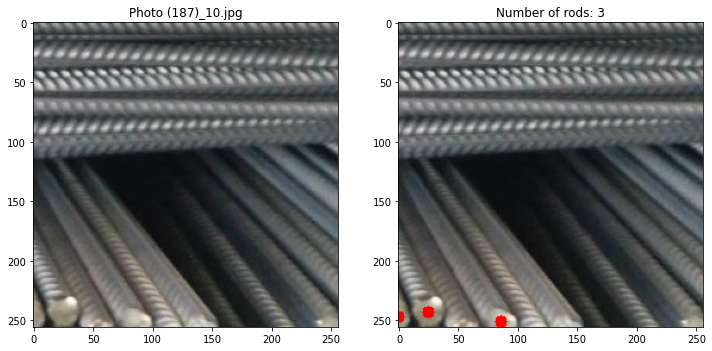

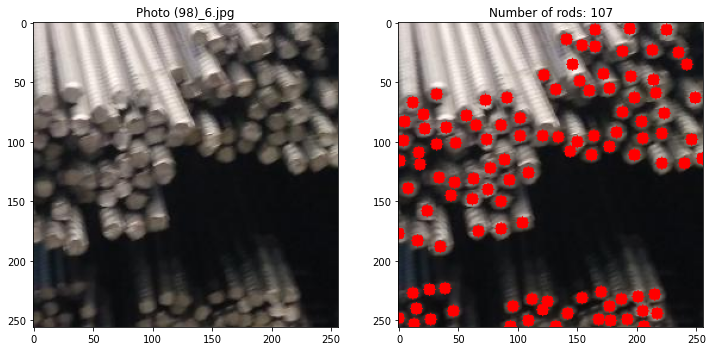

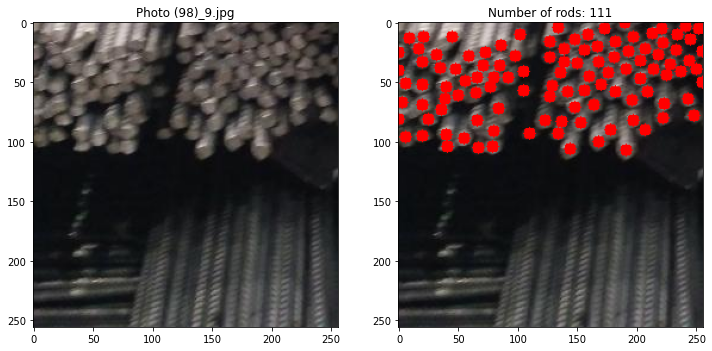

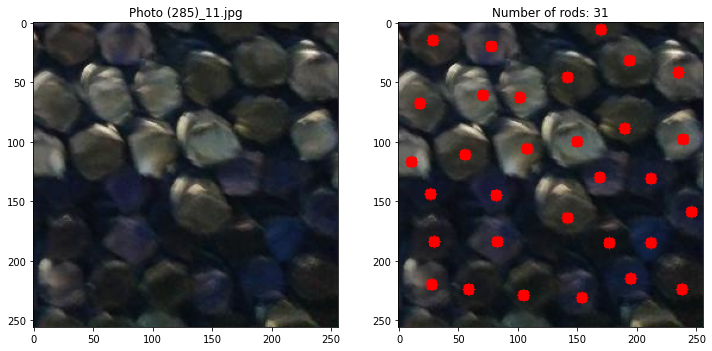

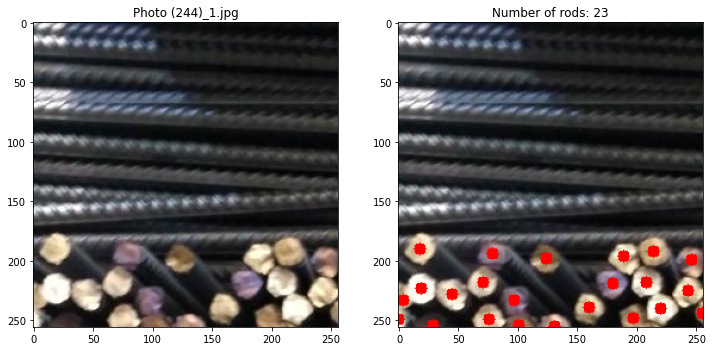

In [5]:
# Let's visualize train data
n = 0
circle_size = 5

while n != 5:
  img_name = np.random.choice(list(train_labels.keys()))
  metadata = train_labels[img_name]
  # rad img
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gt = img.copy()
  # skip zero images
  if img.sum() == 0 or metadata["regions"] == {}:
    continue
  # plot labels
  for i in metadata["regions"].values():
    coords = (i["shape_attributes"]["cx"], i["shape_attributes"]["cy"])
    gt = cv2.circle(gt, coords, circle_size, 255, cv2.FILLED)

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(12,10))
  ax[0].imshow(img)
  ax[0].set_title(metadata["filename"])
  ax[1].imshow(gt)
  ax[1].set_title(f"Number of rods: {len(metadata['regions'].values())}")
  plt.show()

  n += 1

1) We can use cricles to create GT. 2) It's not obvious how to choose optimul circle_size, let's left if 5. 3) We need to left only images that contain some data and some labels.

In [6]:
# left only "normal" data
train_gt = {}

for img_name in tqdm(train_labels):
  metadata = train_labels[img_name]
  if metadata["regions"] == {}:
    continue
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  if img.sum() == 0:
    continue
  train_gt[img_name] = metadata

print(f"New train size: {len(train_gt)}, Previous train size: {len(train_labels)}")

  0%|          | 0/4573 [00:00<?, ?it/s]

New train size: 2632, Previous train size: 4573


In [7]:
# shuffle
keys = list(train_gt.keys())
np.random.shuffle(keys)

# Prepare data for train
train_data, train_labels = [], []
for img_name in keys[:-500]:
  metadata = train_gt[img_name]
  # get data
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  train_data.append(img.astype("float32") / 255)
  # get labels
  gt = np.zeros_like(img[..., :1])
  for i in metadata["regions"].values():
    coords = (i["shape_attributes"]["cx"], i["shape_attributes"]["cy"])
    gt = cv2.circle(gt, coords, circle_size, 1, cv2.FILLED)
  train_labels.append(gt.astype("float32"))

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Prepare data for val
val_data, val_labels = [], []
for img_name in keys[-500:]:
  metadata = train_gt[img_name]
  # get data
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  val_data.append(img.astype("float32") / 255)
  # get labels
  gt = np.zeros_like(img[..., :1])
  for i in metadata["regions"].values():
    coords = (i["shape_attributes"]["cx"], i["shape_attributes"]["cy"])
    gt = cv2.circle(gt, coords, circle_size, 1, cv2.FILLED)
  val_labels.append(gt.astype("float32"))

val_data = np.array(val_data)
val_labels = np.array(val_labels)

print(f"Train data size: {train_data.shape}, Val data size: {val_data.shape}")
print(f"Train labels size: {train_labels.shape}, Val labels size: {val_labels.shape}")

Train data size: (2132, 256, 256, 3), Val data size: (500, 256, 256, 3)
Train labels size: (2132, 256, 256, 1), Val labels size: (500, 256, 256, 1)


In [8]:
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, data, labels, batch_size=1, shuffle=False):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(data))

        # self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append([self.data[j], self.labels[j]])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

In [9]:
train_dataloader = Dataloder(train_data, train_labels, batch_size=16, shuffle=True)
valid_dataloader = Dataloder(val_data, val_labels, batch_size=16, shuffle=True)

## Segmentation Model

In [10]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [11]:
# load pretrained model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]
  
sm.set_framework('tf.keras')
model = sm.Unet(backbone_name='resnet34', classes=1, activation="sigmoid")
model.compile(tf.keras.optimizers.Adam(0.001), loss=sm.losses.dice_loss, metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

85532672/85521592 [==============================] - 1s 0us/step


In [12]:
%%time
# fit model
history = model.fit(train_dataloader,
                    steps_per_epoch=len(train_dataloader),
                    epochs=30,
                    validation_data=valid_dataloader,
                    validation_steps=len(valid_dataloader),
                    callbacks=callbacks)

Epoch 1/30
133/133 [==============================] - 98s 588ms/step - loss: 0.3872 - iou_score: 0.5301 - f1-score: 0.6793 - val_loss: 0.9676 - val_iou_score: 0.0146 - val_f1-score: 0.0288 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - 77s 576ms/step - loss: 0.2294 - iou_score: 0.6431 - f1-score: 0.7814 - val_loss: 0.9994 - val_iou_score: 2.0954e-10 - val_f1-score: 2.0954e-10 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - 76s 575ms/step - loss: 0.2103 - iou_score: 0.6633 - f1-score: 0.7960 - val_loss: 0.9935 - val_iou_score: 0.0029 - val_f1-score: 0.0056 - lr: 0.0010
Epoch 4/30
133/133 [==============================] - 77s 579ms/step - loss: 0.1943 - iou_score: 0.6824 - f1-score: 0.8101 - val_loss: 0.6579 - val_iou_score: 0.2124 - val_f1-score: 0.3431 - lr: 0.0010
Epoch 5/30
133/133 [==============================] - 77s 580ms/step - loss: 0.1838 - iou_score: 0.6960 - f1-score: 0.8197 - val_loss: 0.6409 - val_iou_score: 0.2263 - val_f1-score: 0.

Metrics looks not bad. Let's see on predicts and collect MAPE

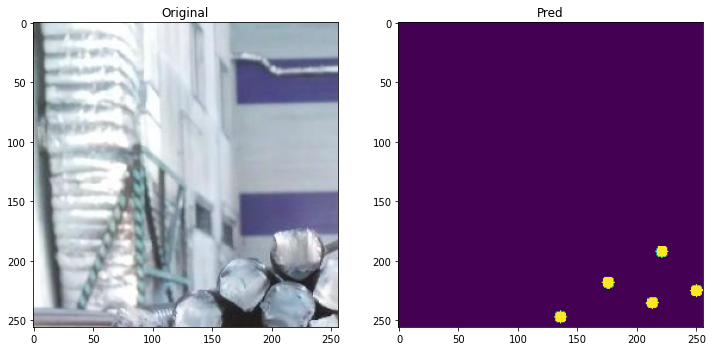

In [13]:
# vis predict
original_img = train_dataloader[0][0][5]
pred = (model.predict(train_dataloader[0][0][5:6]) > 0.5)[0, ..., 0]

# plot
fig, ax = plt.subplots(1, 2, figsize=(12,10))
ax[0].imshow(original_img)
ax[0].set_title("Original")
ax[1].imshow(pred)
ax[1].set_title("Pred")
plt.show()

In [14]:
# Collect MAPE
iters_num = 0
MAPE = []

for img in tqdm(valid_dataloader):
  for i in range(img[0].shape[0]):
    img_original = img[0][i:i+1]
    pred = (model.predict(img_original) > 0.5)[0, ..., 0]
    gt = img[1][i]
    # by connected components
    num_preds, _ = cv2.connectedComponents(pred.astype(np.uint8))
    num_gt, _ = cv2.connectedComponents(gt.astype(np.uint8))
    num_preds -= 1
    num_gt -= 1
    mape_temp = abs((num_gt - num_preds) / num_gt)
    MAPE.append(mape_temp)

    if mape_temp > 2:
      # plot
      print(f"MAPE: {mape_temp}")
      fig, ax = plt.subplots(1, 3, figsize=(12,10))
      ax[0].imshow(img_original[0])
      ax[0].set_title("Original")
      ax[1].imshow(gt[..., 0])
      ax[1].set_title("GT")
      ax[2].imshow(pred)
      ax[2].set_title("Pred")
      plt.show()

    # update iters_num
    iters_num += 1

print(f"MeanAPE: {np.mean(MAPE)}, MedianAPE: {np.median(MAPE)}")

  0%|          | 0/31 [00:00<?, ?it/s]

MeanAPE: 0.10514903350350559, MedianAPE: 0.03540100250626566


In [15]:
# Collect Test Statistics
# Prepare data for test
data_test, labels_test = [], []
for img_name in test_labels:
  metadata = test_labels[img_name]
  # get data
  img = cv2.imread("Пакеты_тест/" + metadata["filename"])
  data_test.append(img.astype("float32") / 255)
  # get labels
  labels_test.append(len(metadata["regions"].values()))

data_test = np.array(data_test)
labels_test = np.array(labels_test)

In [142]:
# Collect MAPE (with crops)
iters_num = 0
MAPE = []

for idx in tqdm(range(data_test.shape[0])):
  img = data_test[idx:idx+1]
  # resize to the closest size
  img = cv2.resize(img[0], (256 * (img.shape[2] // 256), 256 * (img.shape[1] // 256)))
  img = np.expand_dims(img, 0)
  num_preds = 0
  for i in range(img.shape[1] // 256):
    for j in range(img.shape[2] // 256):
      img_crop = img[:, i*256:(i+1)*256, j*256:(j+1)*256]
      pred = (model.predict(img_crop) > 0.5)[0, ..., 0]
      num_preds_crop, _ = cv2.connectedComponents(pred.astype(np.uint8))
      num_preds_crop -= 1
      num_preds += num_preds_crop
  num_gt = labels_test[idx]
  mape_temp = abs((num_gt - num_preds) / num_gt)
  MAPE.append(mape_temp)

  print(f"GT: {num_gt}, Preds: {num_preds}")

  iters_num += 1

print(f"MeanAPE: {np.mean(MAPE)}, MedianAPE: {np.median(MAPE)}")

  0%|          | 0/19 [00:00<?, ?it/s]

GT: 111, Preds: 80
GT: 288, Preds: 50
GT: 105, Preds: 28
GT: 283, Preds: 13
GT: 314, Preds: 18
GT: 393, Preds: 291
GT: 593, Preds: 505
GT: 427, Preds: 27
GT: 471, Preds: 89
GT: 359, Preds: 188
GT: 539, Preds: 70
GT: 396, Preds: 116
GT: 375, Preds: 96
GT: 731, Preds: 76
GT: 495, Preds: 309
GT: 909, Preds: 268
GT: 156, Preds: 225
GT: 1200, Preds: 1219
GT: 134, Preds: 67
MeanAPE: 0.6117954927817137, MedianAPE: 0.7070707070707071


Looks bad, highly likely we need manually crop our data. Lets do it and collect metrics again (only for 4 first images)

In [126]:
# Collect MAPE (with manual crops)
iters_num = 0
MAPE = []
crops_range = [[[900, 2300, 1000, 3200]],
               [[0, 1300, 0, 1800], [1300, -1, 0, 2000], [1300, -1, 2000, -1], [0, 1300, 1800, -1]],
               [[0, -1, 0, 1500], [0, -1, 1500, -1]],
               [[0, 1500, 0, 1000], [1500, -1, 0, 1000], [0,-1,1000,3000], [0,-1,3000,-1]],]

for idx in tqdm(range(data_test.shape[0])):
  img = data_test[idx:idx+1]
  num_preds = 0
  for crop in crops_range[idx]:
    img_crop = img[0][crop[0]:crop[1], crop[2]:crop[3]]
    img_crop = cv2.resize(img_crop, (512, 512))
    img_crop = np.expand_dims(img_crop, 0)
    pred = (model.predict(img_crop) > 0.5)[0, ..., 0]
    num_preds_crop, _ = cv2.connectedComponents(pred.astype(np.uint8))
    num_preds += num_preds_crop - 1

  num_gt = labels_test[idx]

  print(f"GT: {num_gt}, Preds: {num_preds}")

  mape_temp = abs((num_gt - num_preds) / num_gt)
  MAPE.append(mape_temp)

  # break

  iters_num += 1

  if idx == 3:
    break

print(f"MeanAPE: {np.mean(MAPE)}, MedianAPE: {np.median(MAPE)}")

  0%|          | 0/19 [00:00<?, ?it/s]

GT: 111, Preds: 110
GT: 288, Preds: 279
GT: 105, Preds: 81
GT: 283, Preds: 208
MeanAPE: 0.13346202635624013, MedianAPE: 0.12991071428571427


Ok, if we will manually crop test data we will have much better predictions (closer to validation metrics). It's "norm" for competition, but of course it's very bad for production. Maybe it's would be good idea to train some model or apply statistical approach that will "perfectly crop" the data.